# 4-th Exercise - Embeddings, Vector Databases & Search

We will use FAISS and CLIP to create and search pre-trained embedding vectors.

First, we need to install required libraries:

- CLIP: For generating embeddings
- FAISS: For indexing



In [2]:
import sys

# Uncomment as needed
# !{sys.executable} -m pip install --no-input openai-clip 

# Either use CPU-only version
# !conda install --yes --prefix {sys.prefix}  -c pytorch faiss-cpu=1.9.0

# Alternatively use the GPU(+CPU) version
# !conda install --yes --prefix {sys.prefix} -c pytorch -c nvidia faiss-gpu=1.9.0

# !conda install --yes --prefix {sys.prefix}

### Load required libraries

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import faiss
import clip
import json 
import requests

from PIL import Image
from io import BytesIO

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

from tqdm import tqdm

### Some helper methods for testing results

In [4]:
images_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images/"

def load_embeddings(embeddings_path):
    df = pd.read_csv(embeddings_path, sep=';', compression='gzip', index_col=0)

    # Next, we will convert the embeddings String-column into a numpy-vector
    start_time = time.time()
    data = df["embedding"].apply(json.loads).values
    embeddings = np.zeros((data.shape[0], len(data[0])), dtype=np.float32)
    for i, d in enumerate(data):
        embeddings[i] = d
    
    end_time = time.time()
    print(f"Time to load {np.round(end_time-start_time,3)}s")

    return df, embeddings


# Calculate Precision@k
def precision_at_k(indices, k):
    y_true = df.iloc[indices[:,0]]["class"].values
    y_pred = df.iloc[indices.flatten()]["class"].values.reshape(indices.shape[0], -1)
    precisions = []
    # Check how many of the retrieved items are relevant
    for i, pred in enumerate(y_pred[:, :k]):
        relevant = np.sum(y_true[i] == pred)
        precisions.append(relevant / k)
    return np.mean(precisions)

# Plot search results
def plot_results(query_file_names, indices, k):
    if indices is not None:
        for pos, ind in enumerate(indices):
            fig, ax = plt.subplots(1, k+1, figsize=(3*(k+1),4))
    
            if query_file_names:
                path_query = f'{query_file_names[pos]}'
                if os.path.isfile(path_query):     
                    ax[0].imshow(mpimg.imread(path_query))
                    ax[0].axis('off')
                    ax[0].set_title("Query")
                elif len(query_file_names) > pos:
                    # ax[0].set_title()
                    ax[0].text(0.5, 0.5, 
                            f"{query_file_names[pos]}", fontsize=20,
                        ha='center', va='center')
                    ax[0].axis('off')
            else:
                ax[0].remove()
        
            for i in range(0, k):
                d_train = df.iloc[ind[i]]
    
                url = f'{images_URL}/{d_train["dir"]}/{d_train["filename"]}.jpg'
                response = requests.get(url, stream=True)
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))
                    ax[1+i].imshow(img)
                    ax[1+i].axis('off')
                    ax[1+i].set_title(f"{i+1}-NN: " + d_train["class"])
    
                    xy = (d_train["xmin"], d_train["ymin"])
                    width = d_train["xmax"]-d_train["xmin"]
                    height = d_train["ymax"]-d_train["ymin"]
                    rect = Rectangle(xy, width, height, edgecolor='white', fill=None)
                    ax[1+i].add_patch(rect)
                    ax[1+i].text(xy[0], xy[1], d_train["class"], fontsize=12, color='white', 
                                 verticalalignment='bottom', horizontalalignment='left')
                    
                else:
                    ax[i+1].remove()
       
            plt.tight_layout()
            plt.show()

def plot_precision_at_k(indices, k):
    precisions = [precision_at_k(indices, i) for i in range (1,k+1)]
    for i, precision in enumerate(precisions):
        print(f"precision@{i}: {precision}")
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title("Precision@k")
    ax.plot(np.arange(1,k+1, dtype=np.int32), precisions)
    ax.set_xlabel("k")
    ax.set_ylabel("Precision@k")
    plt.show()

### Load Embeddings and Meta-Data

You must download the requires files first, and adapt paths:

- `queries/`: Queries needed for Tasks 1-4. Load from Moodle
- `data/vectors.csv.gz`: Embeddings needed for Tasks 1-5. Load from Moodle

In [5]:
### modify this path, if needed!
queries_start_path = "queries"
embeddings_path = 'data/vectors.csv.gz'

df, embeddings = load_embeddings(embeddings_path)
embedding_dim = embeddings.shape[1]
df.head()

Time to load 3.103s


filename                      dir          class         pose  xmin  \
0    n02097658_26  n02097658-silky_terrier  silky_terrier  Unspecified    41   
1  n02097658_4869  n02097658-silky_terrier  silky_terrier  Unspecified    43   
2   n02097658_595  n02097658-silky_terrier  silky_terrier  Unspecified    82   
3  n02097658_9222  n02097658-silky_terrier  silky_terrier  Unspecified     0   
4   n02097658_422  n02097658-silky_terrier  silky_terrier  Unspecified   146   

   ymin  xmax  ymax                                          embedding  
0    30   296   398  [0.21719056367874146, 0.29560884833335876, 0.0...  
1   270   321   498  [-0.3137703835964203, -0.5720250606536865, 0.0...  
2     7   378   355  [0.10297045111656189, -0.08061640709638596, -0...  
3    12   331   498  [0.20631632208824158, 0.0758294016122818, 0.02...  
4    10   356   332  [0.02929862029850483, -0.12727777659893036, 0....

# Task 1: Exact Search using Flat Index

FAISS implements several metrics and indices for similarity search.

Your task is to index all embeddings using `IndexFlatL2` index first.

```
faiss.IndexFlatL2(d)
...
```

You can read more about their implementation and how to use IndexFlatL2 on their GitHub page: https://github.com/facebookresearch/faiss/wiki

In [6]:
def create_IndexFlatL2(embeddings):    
    # TODO neeed to add you code here
    # faiss.IndexFlatL2(dimension)
    index = faiss.IndexFlatL2(embeddings.shape[1])
    return index


start_time = time.time()
index_flat = create_IndexFlatL2(embeddings)
end_time = time.time()
print(f"Time to index {np.round(end_time-start_time,3)}s")

Time to index 0.0s


# Task 2: Generate embeddings for queries using OpenAI's CLIP

You are given a set of images in the `queries` subfolder. Your task is to:
- Generate CLIP-embedddings for each image
- Search for the image embeddings using the FAISS index

CLIP [1] an embedding model by OpenAI, which is used to extract a high-dimensional vector representation of an image, which captures its semantic and perceptual features.

[1] https://github.com/openai/CLIP

### Initialize OpenAi's CLIP Encoder for feature extraction

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("running on: " + device)
model, preprocess = clip.load("ViT-B/32", device=device)

running on: cuda


### Now Generate Embeddings of Queries

Use CLIP to generate for all images in the queries folder the corresponding embedding.

```python
model.encode_image(image)
```

See: https://github.com/openai/CLIP

Upon generation, make sure to convert all data to float32, which is required to FAISS.

In [8]:
def create_query_embeddings(queries_start_path):

    # Load all images from the queries subfolder
    df_data = pd.DataFrame()
    query_file_names = []
    for root, dirs, files in os.walk(queries_start_path):
        for file_name in files:
            if ".jpg" in file_name:
                query_file_names.append(f"{root}/{file_name}")         

    
    # TODO you need to add you code here
    query_embeddings = np.zeros((0,embeddings.shape[1]), dtype=np.float32)
    for query_file_name in query_file_names:
        image = preprocess(Image.open(query_file_name)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
        query_embeddings = np.vstack((query_embeddings, image_features.cpu().numpy()))
    return query_embeddings, query_file_names

query_embeddings, query_file_names = create_query_embeddings(queries_start_path)

### Querying: Search for top-3 relevant images

We need to define a search function below to first vectorize our query image, and then search for the vectors with the closest distance.

```python
index_flat.search(query_embeddings, k)
```

In [13]:

k = 3

def indexed_search(index, query_embeddings, k):
    # Search for the top-3 nearest neighbors

    # TODO you need to add you code here
    # 确保索引已经训练好
    if not index.is_trained:
        print("Training index...")
        index.train(embeddings)
    
    # 检查索引是否为空
    if index.ntotal == 0:
        print("Adding embeddings to index...")
        index.add(embeddings)
    
    # 执行搜索
    distances, indices = index.search(query_embeddings, k)

    
    return indices


start_time = time.time()
flat_indices = indexed_search(index_flat, query_embeddings, k)
end_time = time.time()
print(f"Time to index {np.round(end_time-start_time,3)}s")

Adding embeddings to index...
Time to index 0.029s


### Plot results

We use the helper function, to illustrate the results

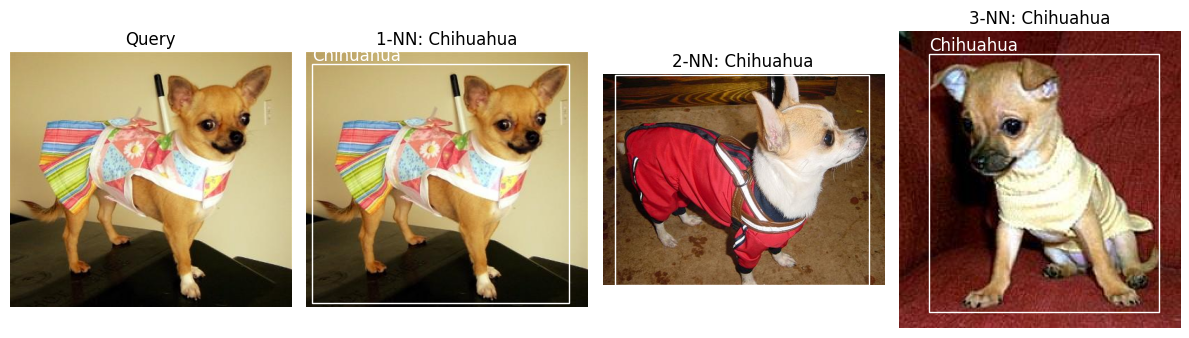

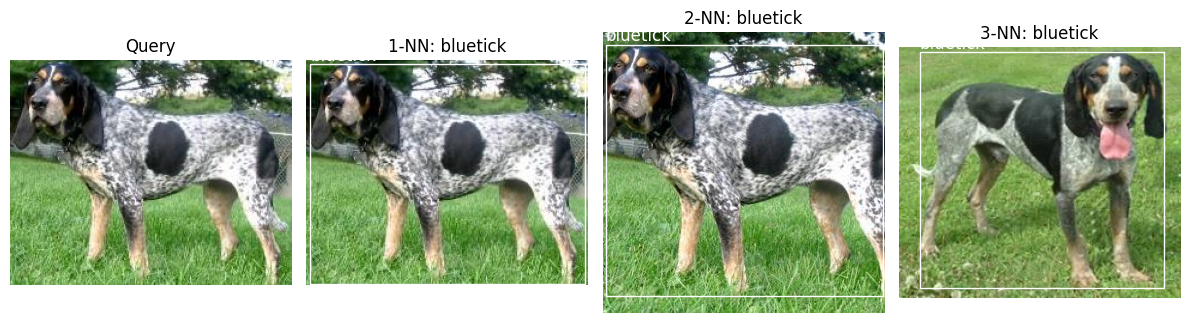

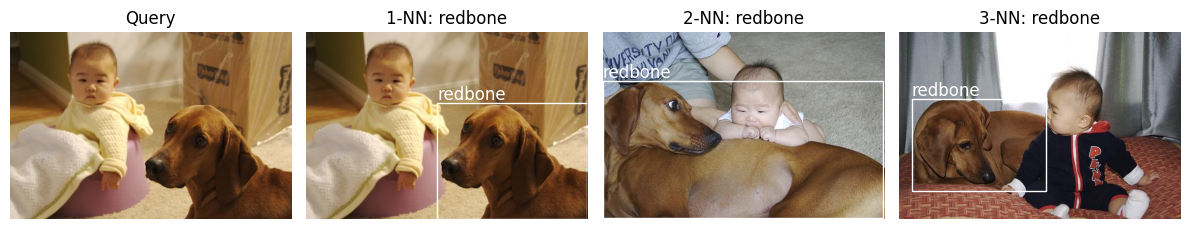

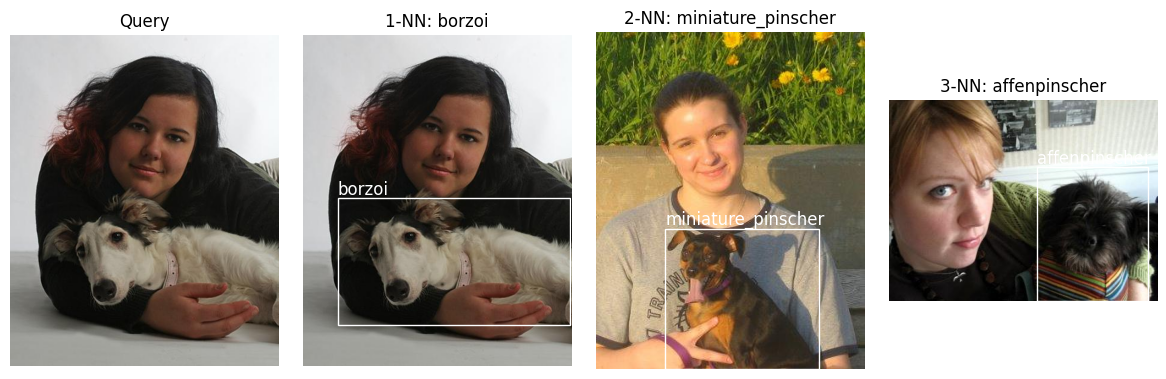

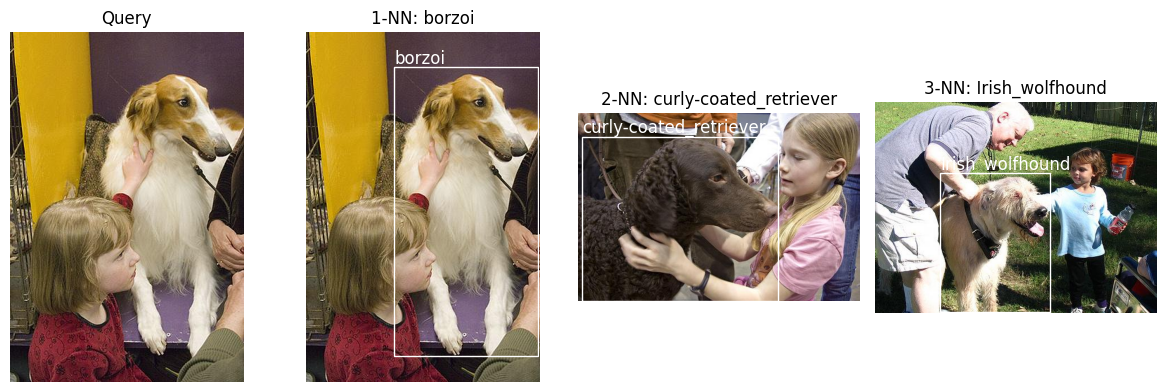

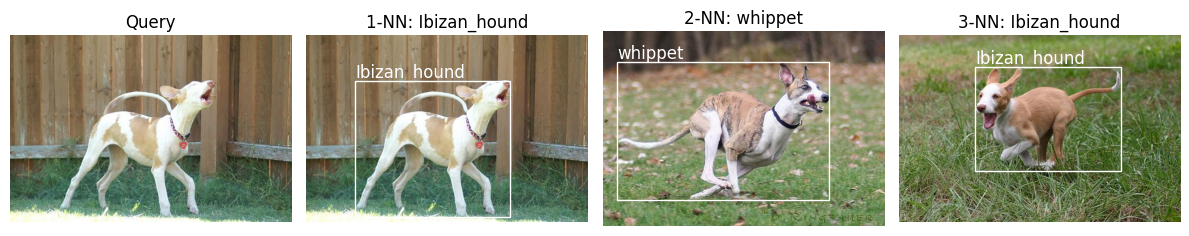

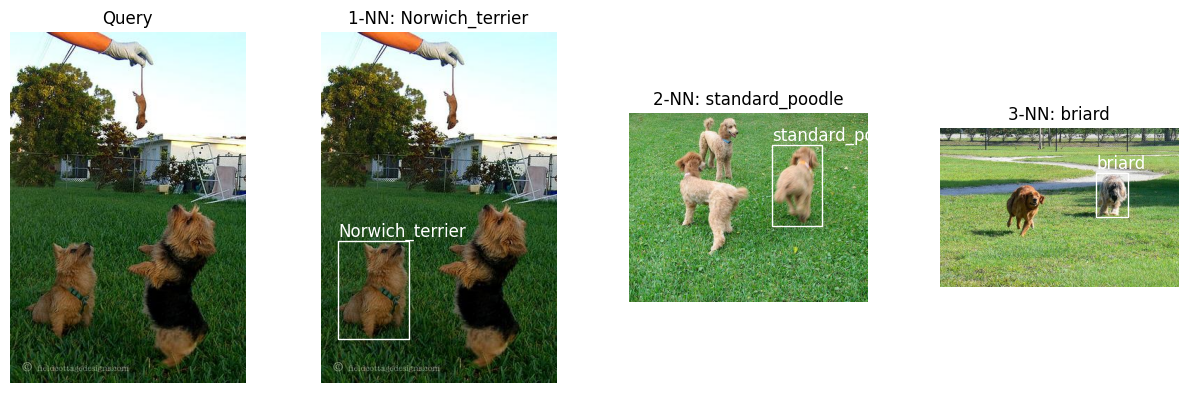

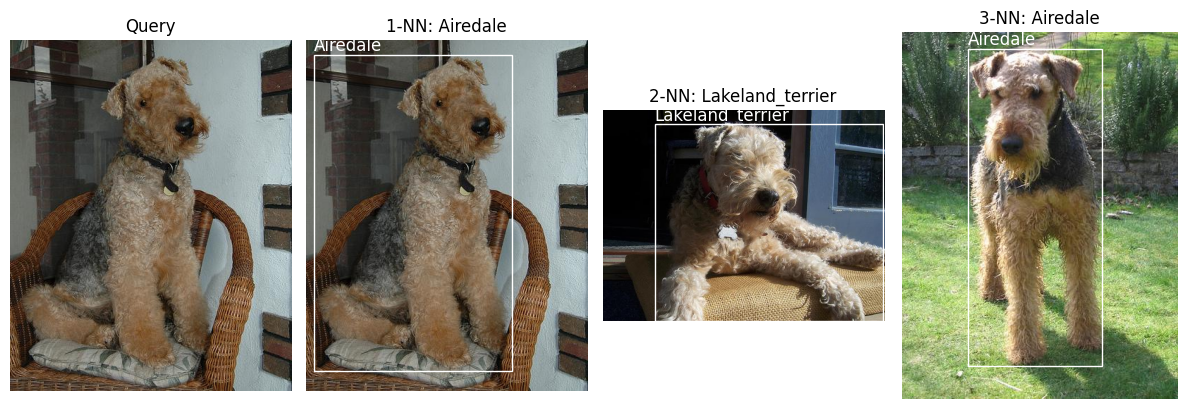

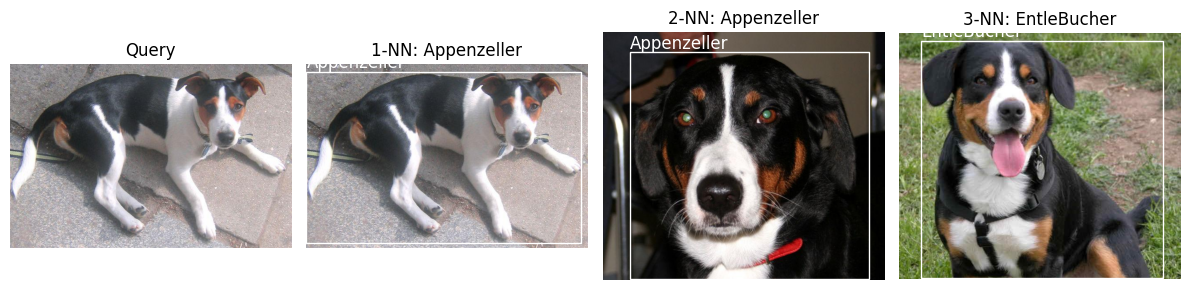

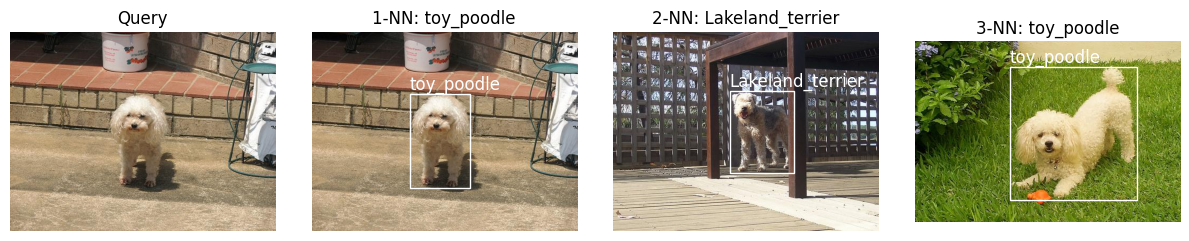

In [14]:
plot_results(query_file_names, flat_indices, k)

### Measure precision@k

We measure the precision@k for different values of k.

precision@0: 1.0
precision@1: 0.7
precision@2: 0.6666666666666667


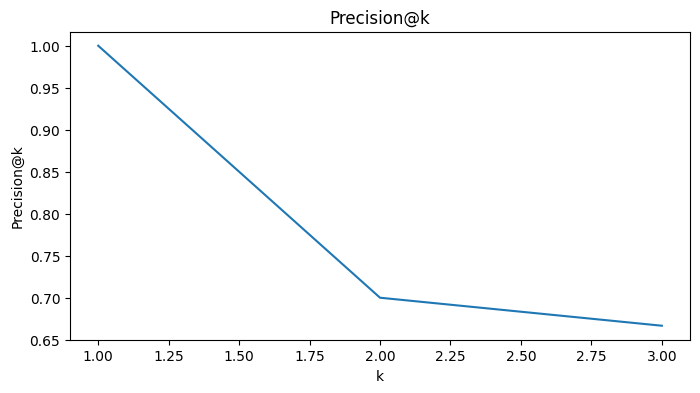

In [15]:
# A simple test to test correctness
if flat_indices is None:
    print("You must implement Task 1 and 2 first")
else:
    assert precision_at_k(flat_indices, 1) == 1.0
    
    plot_precision_at_k(flat_indices, k)

# Task 3: Use Hierarchical Small World Graphs

To use Hierarchical Small World Graphs in FAISS, we need to work with the HNSW (Hierarchical Navigable Small World) index that FAISS provides. HNSW is a type of small-world graph used for approximate nearest neighbor search, which is highly efficient for high-dimensional data.

```python
index = faiss.IndexHNSWFlat(d, M) 
hswg_index.hnsw.efConstruction = ...
hswg_index.hnsw.efSearch = ...

```

Tuning the HNSW Index:
- `M` : A higher value will give more accurate results but with increased memory usage and slower indexing times.
- `EfConstruction`: This parameter controls the number of candidate neighbors that are evaluated during the construction of the graph. A larger value can lead to better quality of the graph at the expense of longer construction time.
- `EfSearch`: This parameter controls the number of candidate neighbors considered during search. A larger value can improve accuracy but makes the search slower.

In [21]:
k=3

def index_and_query_hswg(embeddings, query_embeddings, k):
    
    # TODO add you code here
    dim = embeddings.shape[1]

    hswg_index = faiss.IndexHNSWFlat(dim, 32) # 32 is the number of neighbors to explore. Bigger is more accurate, but slower
    hswg_index.hnsw.efConstruction = 40 # 40 is the number of k-NN, when the graph is constructed. Bigger is more accurate, but slower
    hswg_index.hnsw.efSearch = 64 # 64 is the number of candidates to explore during the search. Biggers is more accurate, but slower

    hswg_index.add(embeddings)

    distances, indices = hswg_index.search(query_embeddings, k)   # used to store the result
    

    return hswg_index, indices


start_time = time.time()
hswg_index, hswg_indices = index_and_query_hswg(embeddings, query_embeddings, k)
end_time = time.time()
print(f"Time to index and query {np.round(end_time-start_time,3)}s")

Time to index and query 0.51s


precision@0: 1.0
precision@1: 0.7
precision@2: 0.6666666666666667


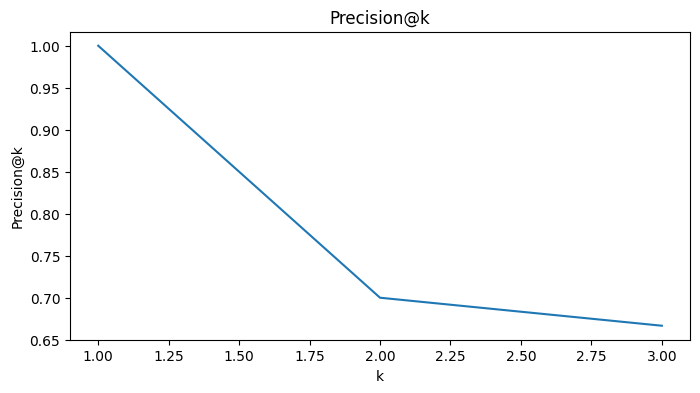

In [22]:
# A simple test to test correctness
if hswg_indices is None:
    print("You must implement Task 3 first")
else:
    assert precision_at_k(hswg_indices, 1) == 1.0
    plot_precision_at_k(hswg_indices, k)

# Task 4: Optimize Hyper-Paramerers

Test different ranges of the three input parameters

```python
M_values = [8, 16, 32]
efConstruction_values = [40, 100, 200]
efSearch_values = [10, 50, 100]
metric_types = [faiss.METRIC_L2, faiss.METRIC_L1]
```

For each parameter, create a `IndexHNSWFlat`, and search for the $5$-NN.

For each set of parameters, record the query-time and the precision@5. Output the best 5 sets of parameters for the best quer-times and the best precision@5.

You may measure runtimes using:
```python
            start_time = time.time()
            ...
            end_time = time.time()

```

In [23]:
# Range of parameters to try for tuning
M_values = [8, 16, 32]
efConstruction_values = [40, 100, 200]
efSearch_values = [10, 50, 100]
metric_types = [faiss.METRIC_L2, faiss.METRIC_L1]
k = 5  # Number of neighbors


def hswg_grid_search(embeddings, query_embeddings, k):
    # TODO need to add you code here
    # For each set of parameters, record (a) the query-time and (b) the precision@5. 
    # Output the best 5 sets of parameters for the best quer-times and the best precision@5.
    results = []
    for M in M_values:
        for efConstruction in efConstruction_values:
            for efSearch in efSearch_values:
                for metric in metric_types:
                    hswg_index = faiss.IndexHNSWFlat(embeddings.shape[1], M, metric)
                    hswg_index.hnsw.efConstruction = efConstruction
                    hswg_index.hnsw.efSearch = efSearch
                    hswg_index.reset()
                    hswg_index.add(embeddings)
                    
                    start_time = time.time()
                    distances, hswg_indices = hswg_index.search(query_embeddings, k)
                    end_time = time.time()
                    query_time = end_time - start_time
                    precision = precision_at_k(hswg_indices, k)

                    results.append((M, efConstruction, efSearch, metric, query_time, precision))
                    
                    print(f"M={M}, efConstruction={efConstruction}, efSearch={efSearch}, metric={metric}: query_time={query_time}, precision@5={precision}")

    # Best performance tracking
    best_params_query_time, best_params_precision_at_5 = [], []
    best_params_query_time = sorted(results, key=lambda x: x[4])[:5]
    best_params_precision_at_5 = sorted(results, key=lambda x: x[5], reverse=True)[:5]

    return best_params_query_time, best_params_precision_at_5


best_params_query_time, best_params_precision_at_5 = hswg_grid_search(embeddings, query_embeddings, k)
# print ("Best Query Time", best_params_query_time)
# Best Query Time Results
print("\n=== Best Query Time Results ===")
for i, result in enumerate(best_params_query_time, 1):
    print(f"{i}. Time: {result[4]:.4f}s, M={result[0]}, efC={result[1]}, efS={result[2]}, Metric={'L2' if result[3]==faiss.METRIC_L2 else 'L1'}")

# Best Precision Results
# print("\n=== Best Precision Results ===")
for i, result in enumerate(best_params_precision_at_5, 1):
    print(f"{i}. Precision: {result[5]:.4f}, M={result[0]}, efC={result[1]}, efS={result[2]}, Metric={'L2' if result[3]==faiss.METRIC_L2 else 'L1'}")
print ("Best Precision@5", best_params_precision_at_5)

M=8, efConstruction=40, efSearch=10, metric=1: query_time=0.0, precision@5=0.4600000000000001
M=8, efConstruction=40, efSearch=10, metric=2: query_time=0.0, precision@5=0.4600000000000001
M=8, efConstruction=40, efSearch=50, metric=1: query_time=0.0, precision@5=0.5200000000000001
M=8, efConstruction=40, efSearch=50, metric=2: query_time=0.0, precision@5=0.5200000000000001
M=8, efConstruction=40, efSearch=100, metric=1: query_time=0.0009996891021728516, precision@5=0.5200000000000001
M=8, efConstruction=40, efSearch=100, metric=2: query_time=0.0010006427764892578, precision@5=0.5200000000000001
M=8, efConstruction=100, efSearch=10, metric=1: query_time=0.0, precision@5=0.5200000000000001
M=8, efConstruction=100, efSearch=10, metric=2: query_time=0.0, precision@5=0.5000000000000001
M=8, efConstruction=100, efSearch=50, metric=1: query_time=0.0010006427764892578, precision@5=0.5200000000000001
M=8, efConstruction=100, efSearch=50, metric=2: query_time=0.00099945068359375, precision@5=0.5

# Task 5: Search for Dogs that look like you.

Use an image of yourself, and find dogs that look like you.

Alternatively: Search the internet and find at least $5$ images of people, who look similar to dogs. For each image, 
- Transform the image using CLIP
- Perform a search using any faiss index and plot the results.

In [ ]:
def dogs_that_look_like_you(embeddings, k):
    # TODO you need to add you code here
    return None

dogs_that_look_like_you(embeddings, k)

# Task 6: Text-To-Image Retrieval

We will now use CLIP text embeddings to find the top-3 matching images. 

You are given a set of sentences. Your task is to:
- Generate CLIP-embedddings for each sentence
- Search for the Top-3 images using `IndexFlatL2` index and Metric `METRIC_L1`

Please refer to [1] for additional information on how to generate text-embeddings.

[1] https://github.com/openai/CLIP

You may add additional sentences to do further experiments.

In [ ]:
k = 3  # Number of neighbors
sentences = ["a lion",
             "a dog and a girl", 
             "a dog and a man", 
             "a toy and a dog",
             "a group of people"]


def text_to_image(embeddings, sentences, k):
    metric = faiss.METRIC_L1
    
    # TODO need to add you code here
    index_flat = None
    indices = None   # used to store the result

    return indices    


indices = text_to_image(embeddings, sentences, k)

if flat_indices is None:
    print("You must implement Task 6")
else:
    assert precision_at_k(flat_indices, 1) == 1.0    
    plot_results(sentences, indices, k)

# Hand in your solution via Moodle

Submit two files:
- This notebook
- A html-export of this notebook